In [2]:
import pandas as pd
import boto3
import sagemaker
import json
import joblib
import xgboost as xgb
from sklearn.metrics import roc_auc_score
import numpy as np
import pyarrow
from math import radians, sin, cos, sqrt, atan2
import time
import io
from io import StringIO, BytesIO
import base64
import pprint
import re
from sagemaker.image_uris import retrieve
import tarfile
import gzip

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


In [3]:
pip install s3fs shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.1/316.1 kB 29.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 32.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2023.6.0
    Uninstalling fsspec-2023.6.0:
      Successfully uninstalled fsspec-2023.6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyter-ai 2.8.1 requires faiss-cpu, which is not installed.
datasets 2.16.1 requires fsspec[http]<=2023.10.0,>=2023.1.0, but you have fsspec 2024.5.0 which is incompatible.
jupyter-scheduler 2.4.0 requires fsspec==2023.6.0, but you have fsspec 2024.5.0 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Note: you may need to restart the kernel to use updated packages.


In [6]:
sess = sagemaker.Session()
write_bucket = sess.default_bucket()
write_prefix = "search-algorithm-demo"

region = sess.boto_region_name
s3_client = boto3.client("s3", region_name=region)
sm_client = boto3.client("sagemaker", region_name=region)
sm_runtime_client = boto3.client("sagemaker-runtime")
sm_autoscaling_client = boto3.client("application-autoscaling")

sagemaker_role = sagemaker.get_execution_role()

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


In [7]:
def read_glue_table(database_name, table_name):
    # Create Glue client
    glue_client = boto3.client('glue')

    # Get the Glue table metadata
    response = glue_client.get_table(DatabaseName=database_name, Name=table_name)
    location = response['Table']['StorageDescriptor']['Location']

    # Read data from the Glue table into a Pandas DataFrame
    try:
        df = pd.read_parquet(location)
        if df.empty:
            raise ValueError("CSV file is empty")
        return df
    except Exception as e:
        print(f"Error reading CSV file: {e}")
        return None

In [32]:
df_nl_tutor = read_glue_table('algorithm_search', 'nl_tutor')
df_nl_student = read_glue_table('algorithm_search', 'nl_student')
df_nl_relations = read_glue_table('algorithm_search', 'student_tutor')

In [33]:
df = df_nl_relations.merge(df_nl_tutor, how='left', on=['tutor'])
df = df.rename(columns={'registration_date': 'tutor_registration_date', 'city': 'tutor_city', 'heard_about': 'tutor_heard_about','latitude': 'tutor_latitude',
                       'longitude': 'tutor_longitude'}) 
df = df.merge(df_nl_student, how='left', left_on='student', right_on='student_id')
df = df.rename(columns={'city': 'student_city', 'heard_about': 'student_heard_about',
                        'latitude': 'student_latitude', 'longitude': 'student_longitude'})
df = df.drop(columns = {'last_active_at_x', 'country_x', 'state_x', 'last_active_at_y', 'country_y', 'state_y', 'student_id', 'registration_date'})

In [34]:
df['student'] = df['student'].astype('str')

df['tutor'] = df['tutor'].astype('str')

df['course'] = df['course'].astype('str')

df['matched'] = df['matched'].astype('bool')

df['tutor_city'] = df['tutor_city'].astype('str')

df['tutor_accepts_new_students'] = df['tutor_accepts_new_students'].astype('bool')

df['tutor_can_teach_online'] = df['tutor_can_teach_online'].astype('bool')

df['tutor_has_availability'] = df['tutor_has_availability'].astype('bool')

df['tutor_course_offerings_count'] = pd.to_numeric(df['tutor_course_offerings_count'], errors='coerce')
zero_count_rows = df[df['tutor_course_offerings_count'].isna()]
count_courses_by_tutor = df.groupby('tutor')['course'].nunique()
df.loc[zero_count_rows.index, 'tutor_course_offerings_count'] = zero_count_rows['tutor'].map(count_courses_by_tutor)
df['tutor_course_offerings_count'] = df['tutor_course_offerings_count'].astype('int64')

df['tutor_intake_date'] = pd.to_datetime(df['tutor_intake_date'])
df['tutor_intake_date'] = df['tutor_intake_date'].dt.tz_localize(None)

df['student_city'] = df['student_city'].astype('str')

df['has_online_lessons'] = df['has_online_lessons'].astype('category')

df['has_package'] = df['has_package'].astype('bool')

df['tutor_type'] = df['tutor_type'].astype('str')

df['previous_lesson'] = df['previous_lesson'].astype('bool')

In [35]:
def haversine(lat1, lon1, lat2, lon2):
    # Convert latitude and longitude from degrees to radians
    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)

    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = 6371 * c  # Radius of the Earth in kilometers

    return distance

#Only cases for that country
df.replace('nan', np.nan, inplace=True)
df = df.dropna(subset=['student_city', 'tutor_city'])
df = df.drop_duplicates()

#Distance
df['distance'] = np.where(df.apply(lambda row: haversine(row['student_latitude'], row['student_longitude'], row['tutor_latitude'], row['tutor_longitude']), axis=1) > df['tutor_max_travel_distance'], 0,
                         round(df.apply(lambda row: haversine(row['student_latitude'], row['student_longitude'], row['tutor_latitude'], row['tutor_longitude']), axis=1), 2))        

#Days since intake when matching
df['tutor_intake_date'] = pd.to_datetime(df['tutor_intake_date'])
df['tutor_days_since_intake'] = np.where(df['tutor_intake_date'].notnull(), (df['matching_date'] - df['tutor_intake_date']).dt.days, 10000)

#Fill missing value
df['student_heard_about'] = df['student_heard_about'].fillna("Not provided")
df['tutor_first_lesson_date'] = df['tutor_first_lesson_date'].fillna(df.matching_date)
df['tutor_manual_weight'] = df['tutor_manual_weight'].fillna(1.0)


#Process new variables
df['tutor_days_to_first_lesson'] = (df['tutor_first_lesson_date'] - df['tutor_registration_date']).dt.days

df['avg_lesson_per_student'] = np.where((df['tutor_total_accepted_lessons'] != 0) & (df['tutor_previous_number_of_students'] != 0), df['tutor_total_accepted_lessons'].astype(float) / df['tutor_previous_number_of_students'].astype(float), 1)

df['tutor_actual_cancellations'] = df['tutor_total_appointment_requests'] - df['tutor_total_accepted_lessons'] - df['tutor_cancellations']
df['tutor_actual_cancellations'] = df['tutor_actual_cancellations'].apply(lambda x: max(0, x))

df['lessons_per_relation'] = np.where(df['number_of_relations'] > 0, df['tutor_total_accepted_lessons'] / df['number_of_relations'], 0)

In [36]:
df = df[((df['tutor_total_appointment_requests'] != 0) & (df['tutor_average_duration'] != 0)) | ((df['tutor_total_appointment_requests'] == 0) & (df['tutor_average_duration'] == 0) & (df['tutor_previous_number_of_students'] == 0))]
df = df.dropna(subset=['has_online_lessons'])
df = df.loc[df.groupby(['student', 'tutor', 'course', 'matched'])['has_online_lessons'].idxmax()].reset_index(drop=True)
df = df.loc[df.groupby(['student', 'tutor', 'course', 'matched'])['matching_date'].idxmax()].reset_index(drop=True)

In [37]:
#multiplier to process the old ranking formula
df['first_multiplier_lessons'] = (np.where(df['tutor_total_accepted_lessons'] > 50, 2, 1)) * \
                                  (np.where(df['tutor_total_accepted_lessons'] > 70, 2, 1)) * \
                                  (np.where(df['tutor_total_accepted_lessons'] > 100, 2, 1)) * \
                                  (np.where(df['tutor_total_accepted_lessons'] > 140, 2, 1)) * \
                                  (np.where(df['tutor_total_accepted_lessons'] > 210, 2, 1)) * \
                                  (np.where(df['tutor_total_accepted_lessons'] > 280, 2, 1)) * \
                                  (np.where(df['tutor_total_accepted_lessons'] > 330, 2, 1)) * \
                                  (np.where(df['tutor_total_accepted_lessons'] > 400, 2, 1))

conditions = [
    (df['tutor_previous_number_of_students'] == 0) & (df['number_of_relations'] < 3),
    (df['tutor_previous_number_of_students'] == 1) & (df['tutor_total_accepted_lessons'] == 1),
    (df['tutor_previous_number_of_students'] != 0) 
]
choices = [
    4,
    1,
    (((df['tutor_total_accepted_lessons'] / df['tutor_previous_number_of_students']) ** 2) / (df['tutor_previous_number_of_students'] ** 2.2)) * df['first_multiplier_lessons']
]
default = 0

df['first_multiplier'] = np.select(conditions, choices, default)
df['first_multiplier'] = np.sqrt(df['first_multiplier'])

df['second_multiplier'] = np.where(df['number_of_relations'] > 0, (1 + df['tutor_previous_number_of_students'])/df['number_of_relations'], 1.4)
df['third_multiplier'] = np.where(df['tutor_has_availability'] == True, 1.2, 0.8)
df['fourth_multiplier'] = np.where((df['tutor_previous_number_of_students'] == 0) & (df['number_of_relations'] < 3) & (df['tutor_days_since_intake'] < 38), 8, 1)
df['offline_multiplier'] = 2.2 * np.where(df['tutor_type'] == 1, 1, 1.3) + 1

#Ranking score
df['tutor_manual_weight'] = df['tutor_manual_weight'].fillna(1)
df['online_rank_score'] = df['first_multiplier'] * df['second_multiplier'] * df['third_multiplier'] * df['fourth_multiplier'] * df['tutor_manual_weight']
df['offline_rank_score'] = df['first_multiplier'] * df['second_multiplier'] * df['third_multiplier'] * df['fourth_multiplier'] * df['tutor_manual_weight']/df['offline_multiplier']
df['old_formula'] = np.where(df['has_online_lessons'] != 1, df['offline_rank_score'], df['online_rank_score']) 

#Drop unecessary columns
df = df.drop(columns=['tutor_registration_date', 'tutor_first_lesson_date', 'matching_date', 'student_longitude', 'student_latitude', 'tutor_latitude', 'tutor_longitude', 'tutor_intake_date', 'tutor_manual_weight', 'student_heard_about'])
df = df.drop(columns=['first_multiplier', 'first_multiplier_lessons', 'second_multiplier', 'third_multiplier', 'fourth_multiplier', 'offline_multiplier', 'online_rank_score', 'offline_rank_score', 'tutor_days_since_intake'])
df = df.drop(columns=['tutor_city', 'student_city', 'tutor_total_appointment_requests', 'student_previous_lessons', 'student_total_accepted_intro_lessons', 'has_online_lessons', 'has_package'])
df = df.drop(columns=['tutor_course_appointment_requests', 'student_total_intro_requests', 'tutor_course_previous_number_of_students', 'tutor_cancellations', 'number_of_relations', 'student_tutor_has_intro'])

In [38]:
from scipy.stats import norm
import statsmodels.api as sm

In [39]:
instrumental_formula = 'matched ~ student_average_duration + created_deals + availabile_hours + online_lesson_rate:tutor_can_teach_online + tutor_accepts_new_students + tutor_max_travel_distance:distance + tutor_course_offerings_count + old_formula + tutor_type + previous_lesson'

probit_model = sm.GLM.from_formula(formula=instrumental_formula, data=df, family=sm.families.Binomial(link=sm.families.links.Probit()))
probit_result = probit_model.fit()
predicted_probabilities = probit_result.predict(df)
probit_lp = probit_result.fittedvalues
mills_ratio = np.exp(-0.5 * probit_lp ** 2) / (np.sqrt(2 * np.pi) * predicted_probabilities)
inverse_mills_ratio = 1 / mills_ratio
df['inverse_mills_ratio'] = inverse_mills_ratio

# Save the model parameters to a file
probit_result.params.to_csv('probit_params.csv', header=False)

# Save the model results itself
import pickle
with open('probit_result.pkl', 'wb') as f:
    pickle.dump(probit_result, f)

In [40]:
import sklearn
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV, GridSearchCV, StratifiedShuffleSplit, StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures, FunctionTransformer
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import PoissonRegressor, ElasticNet
from statsmodels.genmod.families import Poisson
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, r2_score, recall_score, accuracy_score
from sklearn.inspection import PartialDependenceDisplay
from xgboost import XGBRegressor, XGBClassifier
from xgboost import callback
import matplotlib.pyplot as plt
import seaborn as sns
import shap

In [28]:
mean = np.mean(df['tutor_student_number_of_lessons'])
std_dev = 2.5 * np.std(df['tutor_student_number_of_lessons'])

df = df[df['tutor_student_number_of_lessons'].between(mean - std_dev, mean + std_dev)]

X = df.drop(columns=['tutor_student_number_of_lessons', 'student', 'tutor', 'course', 'matched'])
y = df['tutor_student_number_of_lessons']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 2503)
kf = KFold(n_splits=5, shuffle=True, random_state=1900561252)
folds = []
for train_index, val_index in kf.split(X_train):
    folds.append((train_index, val_index))

def rmse_scorer(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2))

scorer = make_scorer(rmse_scorer, greater_is_better=False)

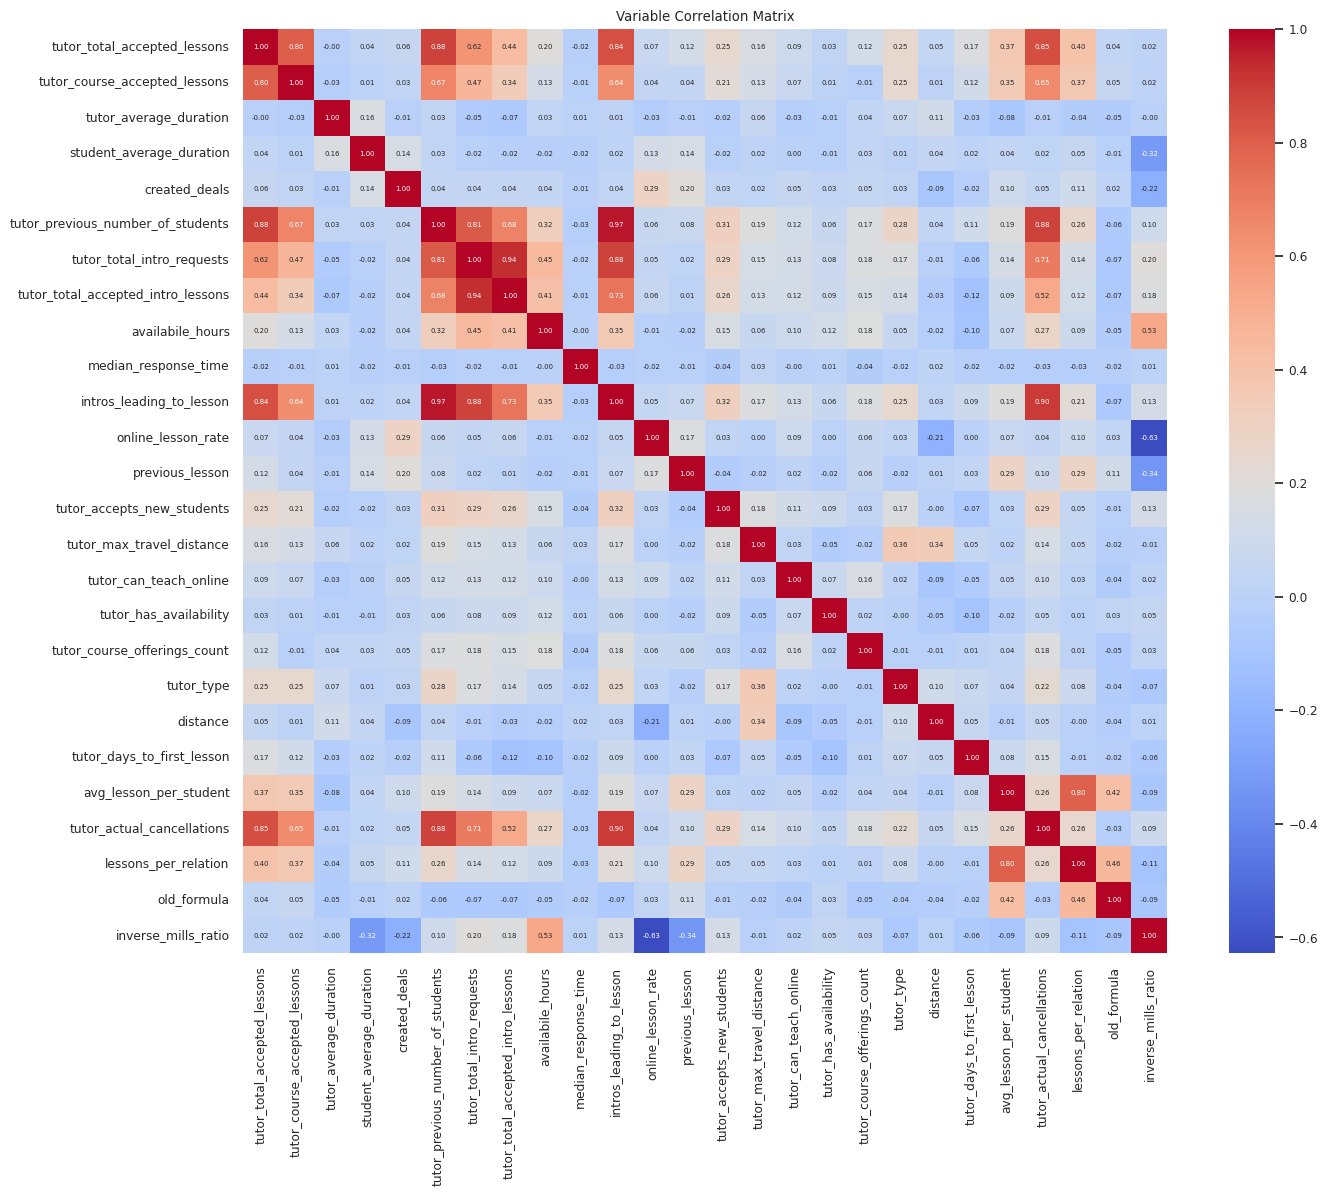

In [17]:
# Calculate the correlation matrix
correlation_matrix = X_train.corr()
sns.set(font_scale=0.8)
plt.figure(figsize=(16, 12))  # Increase the size of the heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 5})  # Adjust annotation font size
plt.title('Variable Correlation Matrix')

# Adjust aspect ratio to make it taller
plt.gca().set_aspect('equal', adjustable='box')

plt.show()

In [48]:
####                             ####
###                               ###
##                                 ##
#              XGBoost              #
##                                 ##
###                               ###
####                             ####

class EarlyStoppingCallback(callback.TrainingCallback):
    def __init__(self, rounds_without_improvement):
        super().__init__()
        self.rounds_without_improvement = rounds_without_improvement
        self.best_score = float('inf')
        self.rounds_since_improvement = 0

    def callback(self, env):
        if 'validation_0' in env.evaluation_result_list:
            validation_loss = env.evaluation_result_list['validation_0']['logloss']
            if validation_loss < self.best_score:
                self.best_score = validation_loss
                self.rounds_since_improvement = 0
            else:
                self.rounds_since_improvement += 1
                if self.rounds_since_improvement >= self.rounds_without_improvement:
                    return True
        return False

# Define preprocessor
xgb_preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), ['tutor_type'])
    ],
    remainder='passthrough'
)

# Define parameter grid for XGBoost
param_dist_xgb = {
    'xgb_regressor__n_estimators': np.linspace(200, 2000, num=9, dtype=int),  
    'xgb_regressor__learning_rate': np.logspace(-2, -1, num=7),
    'xgb_regressor__max_depth': [1, 2],
    'xgb_regressor__colsample_bytree': [0.75, 1.0],
    'xgb_regressor__objective': ['count:poisson']
}


# Create pipeline
pipeline_xgb = Pipeline(steps=[
    ('preprocessor', xgb_preprocessor),
    ('xgb_regressor', XGBRegressor(callbacks=[EarlyStoppingCallback(rounds_without_improvement=500)]))
])

# Initialize GridSearchCV
xgb_model_tune = GridSearchCV(estimator=pipeline_xgb, param_grid=param_dist_xgb, cv=folds, scoring=scorer, verbose=2, n_jobs=4)

# Fit the model
xgb_model_tune.fit(X_train, y_train)

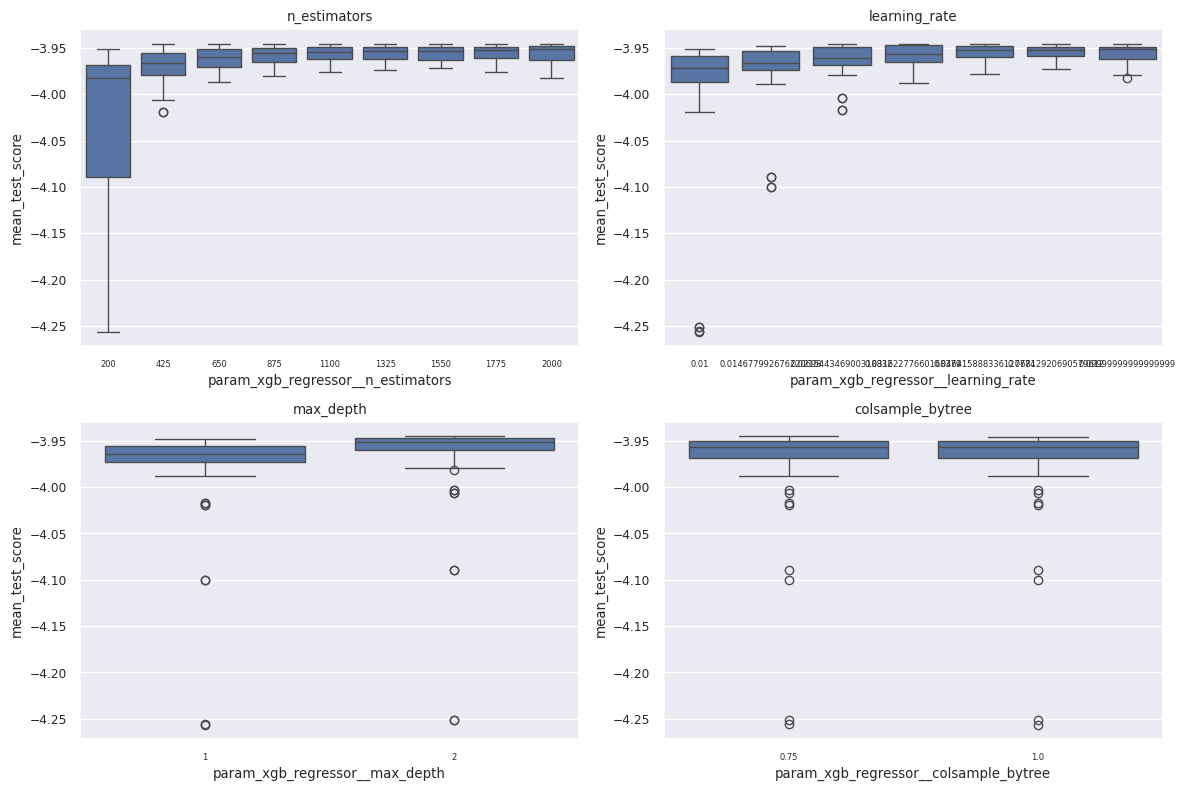

In [19]:
# Extract results from RandomizedSearchCV
results = xgb_model_tune.cv_results_

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Plot results for each hyperparameter
plt.figure(figsize=(12, 8))

# Plot n_estimators
plt.subplot(2, 2, 1)
sns.boxplot(x='param_xgb_regressor__n_estimators', y='mean_test_score', data=results_df)
plt.title('n_estimators')
plt.xticks(fontsize=6)

# Plot learning_rate
plt.subplot(2, 2, 2)
sns.boxplot(x='param_xgb_regressor__learning_rate', y='mean_test_score', data=results_df)
plt.title('learning_rate')
plt.xticks(fontsize=6)

# Plot max_depth
plt.subplot(2, 2, 3)
sns.boxplot(x='param_xgb_regressor__max_depth', y='mean_test_score', data=results_df)
plt.title('max_depth')
plt.xticks(fontsize=6)

# Plot colsample_bytree
plt.subplot(2, 2, 4)
sns.boxplot(x='param_xgb_regressor__colsample_bytree', y='mean_test_score', data=results_df)
plt.title('colsample_bytree')
plt.xticks(fontsize=6)

plt.tight_layout()
plt.show()

In [51]:
pipeline_xgb_best = Pipeline(steps=[
    ('preprocessor', xgb_preprocessor),
    ('xgb_regressor', XGBRegressor(
        n_estimators=1100,
        learning_rate=0.02,
        max_depth=1,
        colsample_bytree=0.75,
        callbacks=[EarlyStoppingCallback(rounds_without_improvement=500)]
    ))
])


# Fit the pipeline
pipeline_xgb_best.fit(X_train, y_train)

# Predict on the training data
y_train_pred_xgb = pipeline_xgb_best.predict(X_train)

# Calculate RMSE
rmse_xgb = rmse_scorer(y_train, y_train_pred_xgb)
print("RMSE for XGBRegressor:", rmse_xgb)

# Get the names of transformed features
xgb_transformed_feature_names = pipeline_xgb_best.named_steps['preprocessor'].get_feature_names_out()

# Get feature importances from the trained XGBRegressor
xgb_feature_importances = pipeline_xgb_best.named_steps['xgb_regressor'].feature_importances_

# Create a DataFrame to store feature importance along with their names
xgb_feature_importance_df = pd.DataFrame({'Feature': xgb_transformed_feature_names, 'Importance': xgb_feature_importances})

# Sort features based on importance scores
xgb_feature_importance_df = xgb_feature_importance_df.sort_values(by='Importance', ascending=False)

# Display feature importance DataFrame
print(xgb_feature_importance_df)

y_test_pred_xgb = pipeline_xgb_best.predict(X_test)
rmse_test_xgb = rmse_scorer(y_test, y_test_pred_xgb)
print("RMSE for test set:", rmse_test_xgb)

RMSE for XGBRegressor: 3.9307728559717576
                                          Feature  Importance
26                         remainder__old_formula    0.222645
11                    remainder__availabile_hours    0.114323
27                 remainder__inverse_mills_ratio    0.112273
22          remainder__tutor_days_to_first_lesson    0.070336
0                               cat__tutor_type_1    0.047765
4        remainder__tutor_course_accepted_lessons    0.045565
8    remainder__tutor_previous_number_of_students    0.038327
7                        remainder__created_deals    0.038003
12                remainder__median_response_time    0.034602
5               remainder__tutor_average_duration    0.032067
6             remainder__student_average_duration    0.031976
21                            remainder__distance    0.027363
3         remainder__tutor_total_accepted_lessons    0.025542
24          remainder__tutor_actual_cancellations    0.025295
25                remainder_

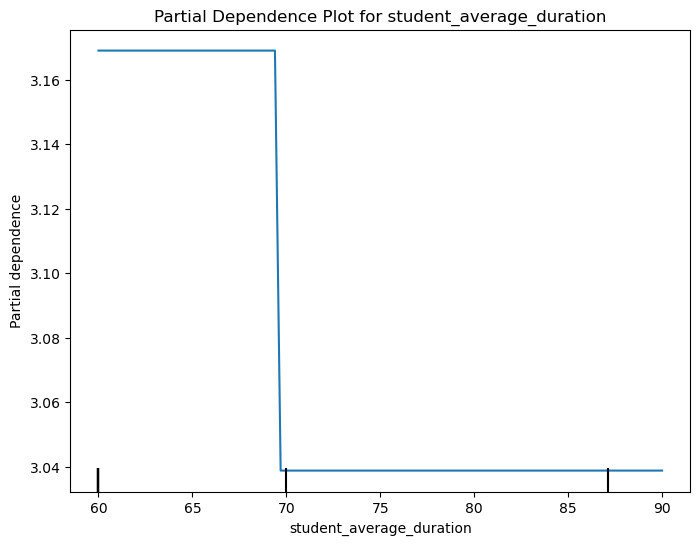

In [72]:
# Select the most important feature and remove the prefix
selected_feature = xgb_feature_importance_df['Feature'].iloc[10]
selected_feature_name = selected_feature.split('__')[-1]

# Generate partial dependence plot
fig, ax = plt.subplots(figsize=(8, 6))
PartialDependenceDisplay.from_estimator(pipeline_xgb_best, X_train, [selected_feature_name], ax=ax)
plt.title(f'Partial Dependence Plot for {selected_feature_name}')
plt.show()

In [26]:
####                             ####
###                               ###
##                                 ##
#     XGBoost - Anonymous data      #
##                                 ##
###                               ###
####                             ####

anonymous_X_train = X_train.drop(columns = ['inverse_mills_ratio', 'student_average_duration', 'created_deals', 'online_lesson_rate', 'previous_lesson'])
anonymous_X_test = X_test.drop(columns = ['inverse_mills_ratio', 'student_average_duration', 'created_deals', 'online_lesson_rate', 'previous_lesson'])

# Initialize RandomizedSearchCV
anonymous_xgb_model_tune = GridSearchCV(estimator=pipeline_xgb, param_grid=param_dist_xgb, cv=folds, scoring=scorer, verbose=2, n_jobs=3)

# Fit the model
anonymous_xgb_model_tune.fit(anonymous_X_train, y_train)

In [ ]:
# Extract results from RandomizedSearchCV
anonymous_results = anonymous_xgb_model_tune.cv_results_

# Convert results to DataFrame
anonymous_results_df = pd.DataFrame(anonymous_results)

# Plot results for each hyperparameter
plt.figure(figsize=(12, 8))

# Plot n_estimators
plt.subplot(2, 2, 1)
sns.boxplot(x='param_xgb_regressor__n_estimators', y='mean_test_score', data=anonymous_results_df)
plt.title('n_estimators')
plt.xticks(fontsize=6)

# Plot learning_rate
plt.subplot(2, 2, 2)
sns.boxplot(x='param_xgb_regressor__learning_rate', y='mean_test_score', data=anonymous_results_df)
plt.title('learning_rate')
plt.xticks(fontsize=6)

# Plot max_depth
plt.subplot(2, 2, 3)
sns.boxplot(x='param_xgb_regressor__max_depth', y='mean_test_score', data=anonymous_results_df)
plt.title('max_depth')
plt.xticks(fontsize=6)

# Plot colsample_bytree
plt.subplot(2, 2, 4)
sns.boxplot(x='param_xgb_regressor__colsample_bytree', y='mean_test_score', data=anonymous_results_df)
plt.title('colsample_bytree')
plt.xticks(fontsize=6)

plt.tight_layout()
plt.show()

In [ ]:
xgb_preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), ['tutor_type'])
    ],
    remainder='passthrough'
)

anonymous_pipeline_xgb_best = Pipeline(steps=[
    ('preprocessor', xgb_preprocessor),
    ('xgb_regressor', XGBRegressor(
        n_estimators=875,
        learning_rate=0.03162277660168379,
        max_depth=1,
        colsample_bytree=0.75,
        callbacks=[EarlyStoppingCallback(rounds_without_improvement=500)]
    ))
])

# Fit the pipeline
anonymous_pipeline_xgb_best.fit(anonymous_X_train, y_train)

# Predict on the training data
anonymous_y_train_pred_xgb = anonymous_pipeline_xgb_best.predict(anonymous_X_train)

# Calculate RMSE
anonymous_rmse_xgb = rmse_scorer(y_train, anonymous_y_train_pred_xgb)
print("RMSE for anonymous XGBRegressor:", anonymous_rmse_xgb)

# Get the names of transformed features
anonymous_xgb_transformed_feature_names = xgb_preprocessor.get_feature_names_out()

# Get feature importances from the trained XGBRegressor
anonymous_xgb_feature_importances = anonymous_pipeline_xgb_best.named_steps['xgb_regressor'].feature_importances_

# Create a DataFrame to store feature importance along with their names
anonymous_xgb_feature_importance_df = pd.DataFrame({'Feature': anonymous_xgb_transformed_feature_names, 'Importance': anonymous_xgb_feature_importances})

# Sort features based on importance scores
anonymous_xgb_feature_importance_df = anonymous_xgb_feature_importance_df.sort_values(by='Importance', ascending=False)

# Display feature importance DataFrame
print(anonymous_xgb_feature_importance_df)

anonymous_y_test_pred_xgb = anonymous_pipeline_xgb_best.predict(anonymous_X_test)
anonymous_rmse_test_xgb = rmse_scorer(y_test, anonymous_y_test_pred_xgb)
print("RMSE for anonymous test set:", anonymous_rmse_test_xgb)

In [ ]:
####                             ####
###                               ###
##                                 ##
#        Variable selection         #
##                                 ##
###                               ###
####                             ####

haha = X_train["old_formula"]
# Define preprocessor
haha_preprocessor = ColumnTransformer(
    transformers=[
    ],
    remainder='passthrough'
)

# Define parameter grid for XGBoost
param_dist_haha = {
    'xgb_regressor__n_estimators': np.linspace(200, 2000, num=9, dtype=int),  
    'xgb_regressor__learning_rate': np.logspace(-2, -1, num=7),
    'xgb_regressor__max_depth': [1, 2],
    'xgb_regressor__colsample_bytree': [0.75, 1.0],
}


# Create pipeline
pipeline_haha = Pipeline(steps=[
    ('preprocessor', haha_preprocessor),
    ('xgb_regressor', XGBRegressor(callbacks=[EarlyStoppingCallback(rounds_without_improvement=500)]))
])

# Initialize GridSearchCV
haha_model_tune = GridSearchCV(estimator=pipeline_haha, param_grid=param_dist_haha, cv=folds, scoring=scorer, verbose=2, n_jobs=4)

# Fit the model
haha_model_tune.fit(X_train, y_train)

In [ ]:
#For error analysis, create prediction datasets

df_y_train_pred_xgb = pd.DataFrame(y_train_pred_xgb, index=y_train.index, columns=['y_train_pred_xgb'])
meta_data = df[['student', 'tutor', 'course', 'matched']]
combined = pd.concat([y_train, df_y_train_pred_xgb], axis=1)
combined_df = pd.concat([X_train, combined], axis=1)
merged_df = pd.merge(meta_data, combined_df, left_index=True, right_index=True, how='inner')
merged_df.to_csv('predictions.csv', index = False)

df_y_train_pred_xgb_anonymous = pd.DataFrame(anonymous_y_train_pred_xgb, index=y_train.index, columns=['y_train_pred_xgb'])
meta_data = df[['student', 'tutor', 'course', 'matched']]
anonymous_combined = pd.concat([y_train, df_y_train_pred_xgb_anonymous], axis=1)
anonymous_combined_df = pd.concat([anonymous_X_train, anonymous_combined], axis=1)
anonymous_merged_df = pd.merge(meta_data, anonymous_combined_df, left_index=True, right_index=True, how='inner')
anonymous_merged_df.to_csv('anonymous_predictions.csv', index = False)

In [24]:
####                             ####
###                               ###
##                                 ##
#        Setup for deployment       #
##                                 ##
###                               ###
####                             ####

#Sample inference request
new_data_df = pd.DataFrame({
    'tutor_total_accepted_lessons': [15, 15, 15],
    'tutor_course_accepted_lessons': [10, 10, 10],
    'tutor_average_duration': [65.0, 65.0, 65.0],
    'tutor_previous_number_of_students': [2, 2, 2],
    'tutor_total_intro_requests': [2, 2, 2],
    'tutor_total_accepted_intro_lessons': [1, 1, 1],
    'availabile_hours': [15, 15, 15],
    'median_response_time': [69, 69, 69],
    'intros_leading_to_lesson': [1, 1, 1],
    'tutor_accepts_new_students': [0, 0, 0],  # Convert False to 0
    'tutor_max_travel_distance': [15.0, 15.0, 15.0],
    'tutor_can_teach_online': [1, 1, 1],  # Convert True to 1
    'tutor_has_availability': [1, 1, 1],  # Convert True to 1
    'tutor_course_offerings_count': [16, 16, 16],
    'tutor_type': [1, 2, 3],
    'distance': [0.0, 0.0, 0.0],
    'tutor_days_to_first_lesson': [150, 0, 0],
    'avg_lesson_per_student': [2.3, 0, 0],
    'tutor_actual_cancellations': [2, 2, 2],
    'lessons_per_relation': [1.7, 2, 2],
    'old_formula': [0.912328542684, 1, 1]
})

# Convert DataFrame to CSV string without column names
csv_string = new_data_df.to_csv(index=False, header=False)

# Create a tar file
tar_filename = 'payload.tar'
with tarfile.open(tar_filename, "w") as tar:
    # Convert CSV string to bytes
    csv_bytes = csv_string.encode('utf-8')
    
    # Add the CSV bytes as a file to the tar
    tarinfo = tarfile.TarInfo('data.csv')
    tarinfo.size = len(csv_bytes)
    tar.addfile(tarinfo, BytesIO(csv_bytes))

# Compress the tar file into tar.gz
tar_gz_filename = 'payload.tar.gz'
with open(tar_filename, 'rb') as f_in:
    with gzip.open(tar_gz_filename, 'wb') as f_out:
        f_out.writelines(f_in)

# Upload the tar.gz file to S3 bucket
s3_client = boto3.client('s3')
bucket_name = 'algorithmsearch'
s3_key = 'Artifact/payload.tar.gz'

s3_client.upload_file(tar_gz_filename, bucket_name, s3_key)

print(f"Payload file '{tar_gz_filename}' uploaded to S3 bucket '{bucket_name}' with key '{s3_key}'")

Payload file 'payload.tar.gz' uploaded to S3 bucket 'algorithmsearch' with key 'Artifact/payload.tar.gz'


In [29]:
training_data = pd.concat([y_train, anonymous_X_train], axis=1)
training_data = pd.get_dummies(training_data, columns=['tutor_type'])
training_data.to_csv('nl_training.csv', index=False)
s3_client.upload_file('nl_training.csv', 'algorithmsearch', 'Artifact/nl_training.csv')

testing_data = pd.concat([y_test, anonymous_X_test], axis=1)
testing_data = pd.get_dummies(testing_data, columns=['tutor_type'])
testing_data.to_csv('nl_validation.csv', index=False)
s3_client.upload_file('nl_validation.csv', 'algorithmsearch', 'Artifact/nl_validation.csv')

full_training_data = pd.concat([y_train, X_train], axis=1)
full_training_data = pd.get_dummies(full_training_data, columns=['tutor_type'])
full_training_data.to_csv('nl_full_training.csv', index=False)
s3_client.upload_file('nl_full_training.csv', 'algorithmsearch', 'Artifact/nl_full_training.csv')

full_testing_data = pd.concat([y_test, X_test], axis=1)
full_testing_data = pd.get_dummies(full_testing_data, columns=['tutor_type'])
full_testing_data.to_csv('nl_full_validation.csv', index=False)
s3_client.upload_file('nl_full_validation.csv', 'algorithmsearch', 'Artifact/nl_full_validation.csv')